<a href="https://colab.research.google.com/github/karnabrajesh/Learning/blob/master/ExploratoryAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import re

In [2]:
def load_tweets():
    return pd.read_csv('/content/sample_data/trump_tweets.csv')

**Load tweets and check for devices with most tweets**

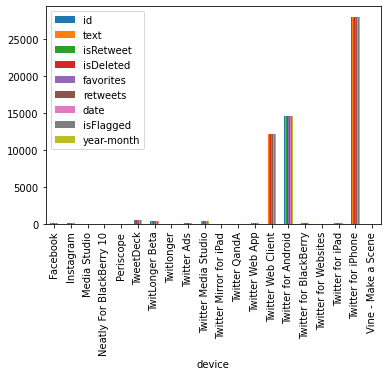

In [3]:
tweet_df = load_tweets()
tweet_df['year-month'] = pd.to_datetime(tweet_df['date']).dt.strftime('%Y-%m')
group_df = tweet_df.groupby('device')
group_df.count().plot.bar()

In [4]:
twitter_for_iPhone_df = group_df.get_group('Twitter for iPhone').set_index(['date']).sort_index()
twitter_web_client_df = group_df.get_group('Twitter Web Client').set_index(['date']).sort_index()
twitter_for_android_df = group_df.get_group('Twitter for Android').set_index(['date']).sort_index()

Getting tweets for as sort with date. Then group by year-month and combine text:
 - Web Client
 - Android
 - iphone

In [5]:
iphone_grouped = twitter_for_iPhone_df.groupby('year-month').agg({'text':'sum'})
android_grouped = twitter_for_android_df.groupby('year-month').agg({'text':'sum'})
web_grouped = twitter_web_client_df.groupby('year-month').agg({'text':'sum'})

In [6]:
iphone_sentiment = []
android_sentiment = []
web_sentiment = []

Using https://pypi.org/project/vaderSentiment/ for sentiment analyzer

In [8]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


     |████████████████████████████████| 125 kB 5.0 MB/s 


In [9]:
#For iphone, android, and web

for index, t in iphone_grouped.iterrows():
  ps = analyzer.polarity_scores(t['text'])
  iphone_sentiment.append({'date':index,'compound':ps['compound']})

for index, t in android_grouped.iterrows():
  ps = analyzer.polarity_scores(t['text'])
  android_sentiment.append({'date':index,'compound':ps['compound']})

for index, t in web_grouped.iterrows():
  ps = analyzer.polarity_scores(t['text'])
  web_sentiment.append({'date':index,'compound':ps['compound']})

In [10]:
iphone_senti_df = pd.DataFrame(iphone_sentiment)
iphone_senti_df['date'] = pd.to_datetime(iphone_senti_df['date']).dt.strftime('%Y')

android_sentiment_df = pd.DataFrame(android_sentiment)
android_sentiment_df['date'] = pd.to_datetime(android_sentiment_df['date']).dt.strftime('%Y')

web_sentiment_df = pd.DataFrame(web_sentiment)
web_sentiment_df['date'] = pd.to_datetime(web_sentiment_df['date']).dt.strftime('%Y')

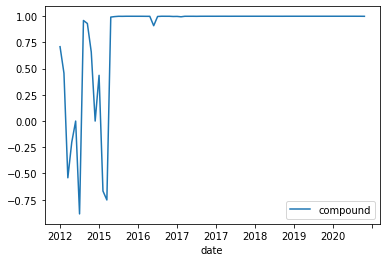

In [11]:
iphone_senti_df.index = iphone_senti_df['date']
iphone_senti_df.plot.line()

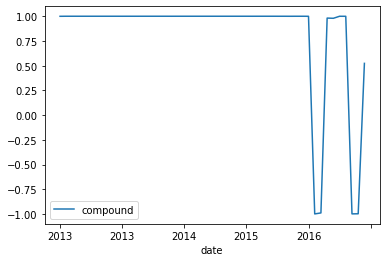

In [12]:
android_sentiment_df.index = android_sentiment_df['date']
android_sentiment_df.plot.line()

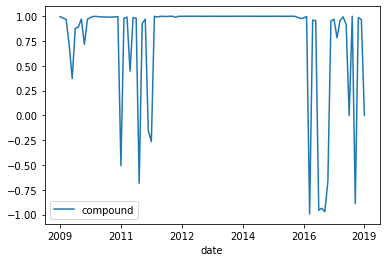

In [13]:
web_sentiment_df.index = web_sentiment_df['date']
web_sentiment_df.plot.line()

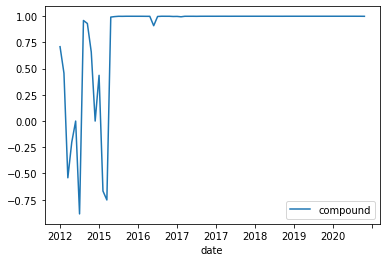

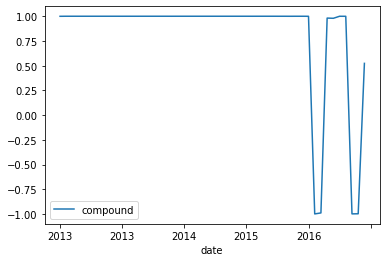

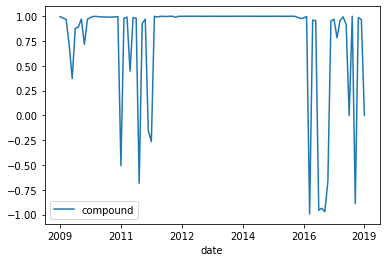

In [14]:
iphone_senti_df.plot.line()
android_sentiment_df.plot.line()
web_sentiment_df.plot.line()

In [15]:
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)    

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

In [16]:
twitter_for_iPhone_df['hashtags'] = twitter_for_iPhone_df.text.apply(find_hashtags)
twitter_for_iPhone_df['mentioned'] = twitter_for_iPhone_df.text.apply(find_mentioned)

twitter_for_android_df['hashtags'] = twitter_for_android_df.text.apply(find_hashtags)
twitter_for_android_df['mentioned'] = twitter_for_android_df.text.apply(find_mentioned)


twitter_web_client_df['hashtags'] = twitter_web_client_df.text.apply(find_hashtags)
twitter_web_client_df['mentioned'] = twitter_web_client_df.text.apply(find_mentioned)


Data Preprocessing

In [18]:
!pip install tweet-preprocessor

In [20]:
import preprocessor as p

def RemoveMentions(text):
    text = re.sub("@[A-Za-z0-9_]+",'',text)
    text = RemoveURL(text)
    return text.strip()

def RemoveURL(text):
    text = re.sub(r"http\S+", "", text)
    return text
    
def RemovePunctuation(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+','', text)
    return text

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

def clean_tweets(df):
  tempArr = []
  for line in df:
    p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER,p.OPT.RESERVED)
    tmpL = p.clean(line)
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) 
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr

twitter_for_iPhone_df['clean_tweet'] = clean_tweets(twitter_for_iPhone_df['text'])
twitter_for_iPhone_df['clean_tweet'] = twitter_for_iPhone_df['clean_tweet'].apply(lambda x: RemoveMentions(x))
twitter_for_iPhone_df['clean_tweet'] = twitter_for_iPhone_df['clean_tweet'].apply(lambda x: RemovePunctuation(x))


twitter_for_android_df['clean_tweet'] = clean_tweets(twitter_for_android_df['text'])
twitter_for_android_df['clean_tweet'] = twitter_for_android_df['clean_tweet'].apply(lambda x: RemoveMentions(x))
twitter_for_android_df['clean_tweet'] = twitter_for_android_df['clean_tweet'].apply(lambda x: RemovePunctuation(x))


twitter_web_client_df['clean_tweet'] = clean_tweets(twitter_web_client_df['text'])
twitter_web_client_df['clean_tweet'] = twitter_web_client_df['clean_tweet'].apply(lambda x: RemoveMentions(x))
twitter_web_client_df['clean_tweet'] = twitter_web_client_df['clean_tweet'].apply(lambda x: RemovePunctuation(x))

In [21]:
def Tokenization(text):
    text = re.split('\W+', text)
    return text

twitter_for_iPhone_df['tweet_tokenized'] = twitter_for_iPhone_df['clean_tweet'].apply(lambda x: Tokenization(x.lower()))
twitter_for_android_df['tweet_tokenized'] = twitter_for_android_df['clean_tweet'].apply(lambda x: Tokenization(x.lower()))
twitter_web_client_df['tweet_tokenized'] = twitter_web_client_df['clean_tweet'].apply(lambda x: Tokenization(x.lower()))


In [22]:
import nltk
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['im','oh','no','yes','http','https','www','click','link','gt','rt','via'])

def RemoveStopwords(text):
    text = [word for word in text if word not in stopword]
    return text

twitter_for_iPhone_df['tweet_without_stopwords']= twitter_for_iPhone_df['tweet_tokenized'].apply(lambda x: RemoveStopwords(x))
twitter_for_android_df['tweet_without_stopwords']= twitter_for_android_df['tweet_tokenized'].apply(lambda x: RemoveStopwords(x))
twitter_web_client_df['tweet_without_stopwords']= twitter_web_client_df['tweet_tokenized'].apply(lambda x: RemoveStopwords(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [23]:
def JoinText(text):
    text = " ".join(text)
    return text

twitter_for_iPhone_df['tweet_without_stopwords']= twitter_for_iPhone_df['tweet_without_stopwords'].apply(lambda x: JoinText(x))
iPhonetweetList = twitter_for_iPhone_df['tweet_without_stopwords'].tolist()
iPhonetweets = ' '.join(iPhonetweetList)
iPhonewords = iPhonetweets.split()

twitter_for_android_df['tweet_without_stopwords']= twitter_for_android_df['tweet_without_stopwords'].apply(lambda x: JoinText(x))
androidtweetList = twitter_for_android_df['tweet_without_stopwords'].tolist()
androidtweets = ' '.join(androidtweetList)
androidwords = androidtweets.split()

twitter_web_client_df['tweet_without_stopwords']= twitter_web_client_df['tweet_without_stopwords'].apply(lambda x: JoinText(x))
webtweetList = twitter_web_client_df['tweet_without_stopwords'].tolist()
webtweets = ' '.join(webtweetList)
webwords = webtweets.split()



In [24]:
twitter_for_iPhone_df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged,year-month,hashtags,mentioned,clean_tweet,tweet_tokenized,tweet_without_stopwords
date,,,,,,,,,,,,,,
2012-12-11 01:20:01,278308122500661248,"Good luck to Bob Kraft, Tom Brady, and Coach B...",f,f,Twitter for iPhone,380,629,f,2012-12,[],[],good luck to bob kraft tom brady and coach bil...,"[good, luck, to, bob, kraft, tom, brady, and, ...",good luck bob kraft tom brady coach bill belic...
2013-02-24 13:33:09,305671710382899200,"I'm saying that the Tea Party, perhaps by anot...",f,f,Twitter for iPhone,101,158,f,2013-02,[],[],im saying that the tea party perhaps by anothe...,"[im, saying, that, the, tea, party, perhaps, b...",saying tea party perhaps another name soon ano...
2013-03-10 18:22:57,310818070610472962,"I'm at Trump Doral right now, Tiger will tee o...",f,f,Twitter for iPhone,122,75,f,2013-03,[],[],im at trump doral right now tiger will tee off...,"[im, at, trump, doral, right, now, tiger, will...",trump doral right tiger tee shortly
2013-03-10 18:34:41,310821024277078017,I will be live tweeting during the @Apprentice...,f,f,Twitter for iPhone,34,51,f,2013-03,[],[@ApprenticeNBC],i will be live tweeting during the tonight at ...,"[i, will, be, live, tweeting, during, the, ton...",live tweeting tonight pm et
2013-03-30 19:43:06,318085997000806400,We have tremendous economic power over China i...,f,f,Twitter for iPhone,90,193,f,2013-03,[],[],we have tremendous economic power over china i...,"[we, have, tremendous, economic, power, over, ...",tremendous economic power china leaders knew u...


In [30]:
from operator import itemgetter
from collections import Counter

def most_common(instances):
    return sorted(sorted(Counter(instances).items(), key=itemgetter(0)), key=itemgetter(1), reverse=True)

iphone_word_freq = most_common(iPhonewords)
iphone_word_percentage = [(instance, count / len(iPhonewords)*100) for instance, count in iphone_word_freq]

android_word_freq = most_common(androidwords)
android_word_percentage = [(instance, count / len(androidwords)*100) for instance, count in android_word_freq]

web_word_freq = most_common(webwords)
web_word_percentage = [(instance, count / len(webwords)*100) for instance, count in web_word_freq]



In [58]:
iphone_word_percentage[:10]
iphone_word_freq[:10]

[('great', 4030),
 ('amp', 3518),
 ('president', 2874),
 ('trump', 2637),
 ('people', 2233),
 ('thank', 2232),
 ('democrats', 1724),
 ('us', 1633),
 ('news', 1554),
 ('new', 1481)]

In [54]:
iphone_word_percentage_df = pd.DataFrame(iphone_word_percentage, columns=['word', 'percentage'])
android_word_percentage_df = pd.DataFrame(android_word_percentage, columns=['word', 'percentage'])
web_word_percentage_df = pd.DataFrame(web_word_percentage, columns=['word', 'percentage'])



In [55]:
iphone_word_percentage_df['percentage']=iphone_word_percentage_df['percentage'].apply(lambda x:round(x,2))
android_word_percentage_df['percentage']=android_word_percentage_df['percentage'].apply(lambda x:round(x,2))
web_word_percentage_df['percentage']=web_word_percentage_df['percentage'].apply(lambda x:round(x,2))

In [81]:
web_word_percentage_df.head()


,word,percentage
0,trump,1.44
1,great,1.32
2,amp,1.30
3,thanks,0.96
4,obama,0.70


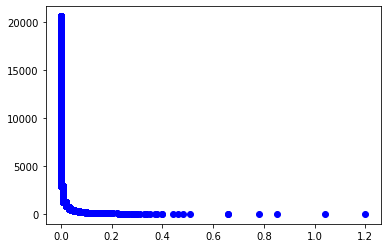

In [74]:
#iphone word% to rows
plt.scatter(np.array(iphone_word_percentage_df['percentage']), np.array(range(0,20637)), c ="blue")


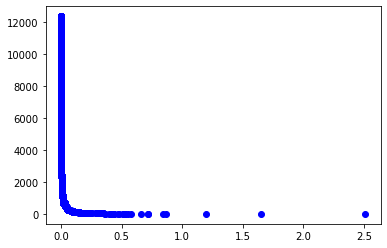

In [78]:
#Android words%
plt.scatter(np.array(android_word_percentage_df['percentage']), np.array(range(0,12378)), c ="blue")

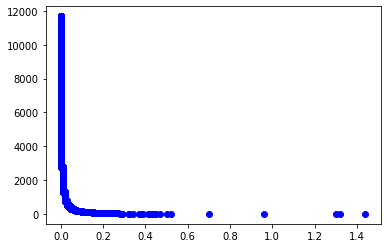

In [80]:
plt.scatter(np.array(web_word_percentage_df['percentage']), np.array(range(0,11682)), c ="blue")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20637 entries, 0 to 20636
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    20637 non-null  object
 1   freq    20637 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 322.6+ KB


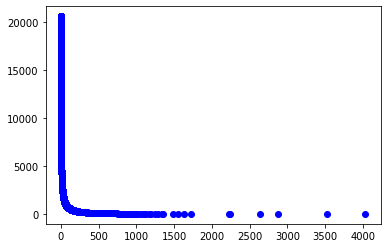

In [88]:
iphone_word_freq_df = pd.DataFrame(iphone_word_freq, columns=['word', 'freq'])
iphone_word_freq_df.info()
plt.scatter(np.array(iphone_word_freq_df['freq']), np.array(range(0,20637)), c ="blue")


In [89]:
iphone_word_freq_df.sort_values(by=['freq'])
iphone_word_freq_df.head(20)


,word,freq
0,great,4030
1,amp,3518
2,president,2874
3,trump,2637
4,people,2233
5,thank,2232
6,democrats,1724
7,us,1633
8,news,1554
9,new,1481


In [90]:
android_word_freq_df = pd.DataFrame(android_word_freq, columns=['word', 'freq'])
android_word_freq_df.sort_values(by=['freq'])
android_word_freq_df.head(20)


,word,freq
0,trump,3144
1,great,2075
2,president,1509
3,thanks,1091
4,donald,1050
5,would,908
6,run,902
7,thank,826
8,people,734
9,like,696


In [92]:
web_word_freq_df = pd.DataFrame(web_word_freq, columns=['word', 'freq'])
web_word_freq_df.sort_values(by=['freq'])
web_word_freq_df.head(20)

,word,freq
0,trump,1448
1,great,1330
2,amp,1308
3,thanks,968
4,obama,701
5,donald,524
6,new,500
7,thank,477
8,good,453
9,like,442


In [97]:
iPhone_hashtags_list_df = twitter_for_iPhone_df.loc[twitter_for_iPhone_df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]
iphone_flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in iPhone_hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])


iphone_popular_hashtags = iphone_flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
iphone_popular_hashtags.head(10)


,hashtag,counts
0,#MAGA,486
1,#Trump2016,344
2,#MakeAmericaGreatAgain,321
3,#AmericaFirst,88
4,#KAG2020,74
5,#DrainTheSwamp,66
6,#COVID19,66
7,#Trump2016https,64
8,#VoteTrump,52
9,#USMCA,42


In [98]:
android_hashtags_list_df = twitter_for_android_df.loc[twitter_for_android_df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

android_flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in android_hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])


android_popular_hashtags = android_flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
android_popular_hashtags.head(10)

,hashtag,counts
0,#Trump2016,378
1,#MakeAmericaGreatAgain,164
2,#CelebApprentice,127
3,#CelebrityApprentice,117
4,#Trump,58
5,#trump2016,54
6,#TrumpForPresident,45
7,#DemDebate,24
8,#GOP,21
9,#trumpforpresident,21


In [100]:
web_hashtags_list_df = twitter_web_client_df.loc[twitter_web_client_df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

web_flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in web_hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])


web_popular_hashtags = web_flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
web_popular_hashtags.head(10)

,hashtag,counts
0,#CelebApprentice,129
1,#trumpvlog,55
2,#MakeAmericaGreatAgain,50
3,#TimeToGetTough,46
4,#Trump2016,36
5,#BigLeagueTruth,33
6,#Debate,30
7,#CelebrityApprentice,20
8,#Debates2016,18
9,#sweepstweet,18


In [102]:
iPhone_mentioned_list_df = twitter_for_iPhone_df.loc[twitter_for_iPhone_df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['mentioned']]

iphone_flattened_mentions_df = pd.DataFrame(
    [mentioned for mentioned_list in iPhone_mentioned_list_df.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])

iphone_popular_mentioned = iphone_flattened_mentions_df.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

iphone_popular_mentioned.head(10)

,mentioned,counts
0,@realDonaldTrump,239
1,@POTUS,55
2,@FoxNews,34
3,@WhiteHouse,32
4,@FLOTUS,22
5,@HillaryClinton,19
6,@IvankaTrump,15
7,@VP,14
8,@foxandfriends,12
9,@CNN,10


In [105]:
android_mentioned_list_df = twitter_for_android_df.loc[twitter_for_android_df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['mentioned']]

android_flattened_mentions_df = pd.DataFrame(
    [mentioned for mentioned_list in android_mentioned_list_df.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])

android_popular_mentioned = android_flattened_mentions_df.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

android_popular_mentioned.head(10)

,mentioned,counts
0,@realDonaldTrump,1574
1,@ApprenticeNBC,64
2,@FoxNews,39
3,@IvankaTrump,33
4,@foxandfriends,30
5,@CNN,20
6,@realdonaldtrump,18
7,@BrandiGlanville,15
8,@LeezaGibbons,15
9,@DanScavino,14


In [108]:
web_mentioned_list_df = twitter_web_client_df.loc[twitter_web_client_df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['mentioned']]

web_flattened_mentions_df = pd.DataFrame(
    [mentioned for mentioned_list in web_mentioned_list_df.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])

web_popular_mentioned = web_flattened_mentions_df.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

web_popular_mentioned.head(10)

,mentioned,counts
0,@realDonaldTrump,142
1,@HillaryClinton,21
2,@MittRomney,17
3,@BarackObama,16
4,@SquawkCNBC,14
5,@THEGaryBusey,14
6,@ApprenticeNBC,12
7,@TrumpDoral,10
8,@Omarosa,9
9,@IvankaTrump,9
